# Deepfake Detection Project: 67-426 (EDA)
## Team Quarks: Ali & Belal
Fall 2023

---

## Introduction

Deepfake technology, driven by artificial intelligence, has emerged as a significant digital threat, capable of creating realistic-looking videos where individuals appear to say or do things they never did. The potential misuse of deepfake technology for misinformation, fraud, and harassment underscores the importance of developing effective detection methods. This project aims to tackle the challenge of deepfake detection by employing machine learning models to distinguish between genuine and manipulated videos.

---

## Dataset Overview

The dataset utilized in this project originates from the Deepfake Detection Challenge (DFDC) hosted on Kaggle. It provides a large collection of videos, both real and AI-manipulated, allowing for comprehensive training and evaluation of our models. The dataset is organized into training, public validation, and test sets, with the training set being further segmented into 50 files for easier access and handling.

---

## Data Analysis

### Data Loading and Exploration

```python
# Import necessary libraries

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline 
import cv2 as cv
from IPython.display import Video
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Load metadata file

In [2]:
df = pd.read_csv('full_metadata.csv')

# Comparing the amount of original vs deepfake videos in the dataset.

In [3]:
n_orig = df['original_file'].unique().shape[0]
n_fake = df['deepfake_file'].unique().shape[0]

print(f"Number of original videos: {n_orig}")
print(f"Number of deepfake videos: {n_fake}")

Number of original videos: 19154
Number of deepfake videos: 100000


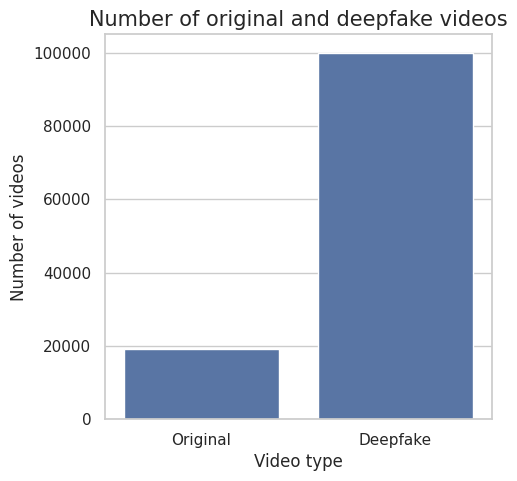

In [4]:
sns.set(style="whitegrid")
plt.figure(figsize=(5, 5))
sns.barplot(x=['Original', 'Deepfake'], y=[n_orig, n_fake], color="b")
plt.ylabel('Number of videos', fontsize=12)
plt.xlabel('Video type', fontsize=12)
plt.title('Number of original and deepfake videos', fontsize=15)
plt.show()

# Class Distribution Analysis

The dataset exhibits a significant class imbalance:

- **Original Videos**: 19,154
- **Deepfake Videos**: 100,000

This shows a higher prevalence of deepfake videos compared to original videos, with a ratio of approximately 1:5.2. This imbalance may need addressing during model training to avoid bias towards detecting deepfake videos.


# Sample Deepfake Video

Below is a sample from the dataset, showcasing what a deepfake video looks like. Understanding the visual nuances of deepfake videos will be crucial in developing an effective detection model.


In [6]:
Video("sample_data/train_sample_videos/aagfhgtpmv.mp4", embed=True)

# Checking the reuse of orginal videos

In [7]:
df['original_file'].value_counts().head()

original_file
tfyyefqpfs.mp4    40
ypgayhhaxx.mp4    39
rqsotnryhj.mp4    39
zgdtjzfrad.mp4    39
gcyecnxtht.mp4    38
Name: count, dtype: int64

# Reuse of Original Videos for Deepfake Generation

The analysis reveals that certain original videos are used multiple times to create deepfake versions, with the top original video being utilized to generate 40 deepfake videos.


# Face Detection in Video Frames
In this section, we aim to extract frames from a sample video and utilize OpenCV for face detection. Understanding and visualizing the frame content is the first step towards building a robust deepfake detection model. 


### Extracting a Frame

We'll begin by extracting a frame from a sample video to understand the visual content. The following code demonstrates how to extract the first frame from the video `cqrskwiqng.mp4` and display it using Matplotlib.


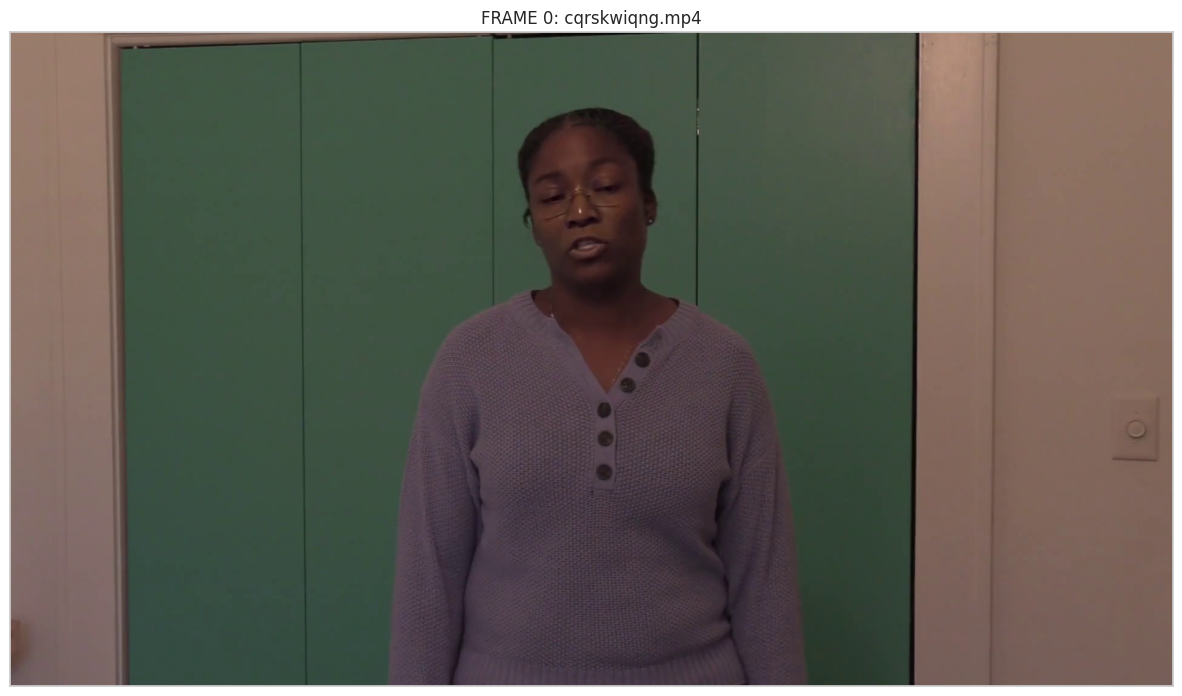

In [16]:
import matplotlib.pylab as plt
train_dir = '/data1/belalm/Capstone/sample_data/train_sample_videos/'
fig, ax = plt.subplots(1,1, figsize=(15, 15))
train_video_files = [train_dir + x for x in os.listdir(train_dir)]
# video_file = train_video_files[10]
video_file = '/data1/belalm/Capstone/sample_data/train_sample_videos/cqrskwiqng.mp4'
cap = cv.VideoCapture(video_file)
success, image = cap.read()
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
cap.release()   
ax.imshow(image)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.title.set_text(f"FRAME 0: {video_file.split('/')[-1]}")
plt.grid(False)

### Face Detection using OpenCV and face_recognition package

Now, we will leverage the `face_recognition` package alongside OpenCV to detect faces within the video frame. 

In [17]:
!pip install face_recognition

1056.35s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 11.0 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 15.6 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for dlib: filename=dlib-19.24.2-cp310-cp310-linux_x86_64.whl size=3855582 sha256=b430bd0f0325d57fc21ae980fb59e2a428596fed1cba381c1d09aaa78fb0cf4e
  Stored in directory: /data1/akq/.cache/pip/wheels/9b/e2/80/888fdc098db86b463ff0c83ae5e5ca151889e901bc1e9a3a11
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566186 sha256=0e77b5cd0d3a30de160aa864cd4f96a0986bdddf03f1c6a3e3d05812754beb0b
  Stored in directory: /data1/akq/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfca

### Locating Face within an Image

Utilizing the `face_recognition` library, we'll now pinpoint the faces present in a video frame. This library simplifies the process of identifying the coordinates where faces are located within an image.

I found 1 face(s) in this photograph.
A face is located at pixel location Top: 192, Left: 835, Bottom: 415, Right: 1058


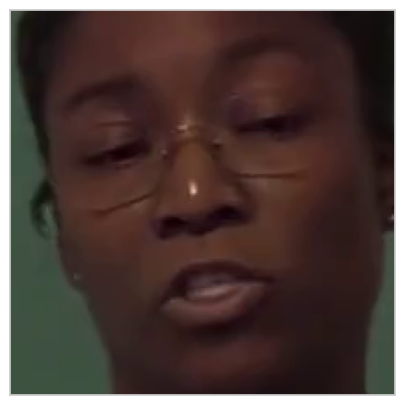

In [18]:
import face_recognition
face_locations = face_recognition.face_locations(image)

from PIL import Image

print("I found {} face(s) in this photograph.".format(len(face_locations)))

for face_location in face_locations:

    # Print the location of each face in this image
    top, right, bottom, left = face_location
    print("A face is located at pixel location Top: {}, Left: {}, Bottom: {}, Right: {}".format(top, left, bottom, right))

    face_image = image[top:bottom, left:right]
    fig, ax = plt.subplots(1,1, figsize=(5, 5))
    plt.grid(False)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.imshow(face_image)

### Locating Facial Landmarks within an Image

In this section, we extend our face analysis to identify the landmarks - distinctive points like the corners of the eyes, the tip of the nose, etc., within a face. This is crucial for understanding the geometry of the face which might be altered in deepfake videos. The `face_recognition` library has a simple method to get these landmarks.

The chin in this face has the following points: [(857, 294), (862, 316), (869, 338), (877, 359), (888, 379), (902, 397), (919, 410), (940, 419), (962, 419), (985, 413), (1007, 402), (1026, 386), (1040, 365), (1048, 341), (1051, 315), (1050, 288), (1048, 261)]
The left_eyebrow in this face has the following points: [(866, 252), (873, 238), (886, 230), (902, 228), (915, 232)]
The right_eyebrow in this face has the following points: [(951, 224), (966, 213), (983, 209), (1001, 212), (1015, 223)]
The nose_bridge in this face has the following points: [(936, 256), (938, 271), (939, 285), (940, 300)]
The nose_tip in this face has the following points: [(924, 320), (934, 321), (945, 322), (957, 317), (967, 314)]
The left_eye in this face has the following points: [(883, 280), (892, 275), (902, 272), (914, 273), (905, 277), (895, 280)]
The right_eye in this face has the following points: [(968, 263), (978, 258), (989, 257), (1000, 258), (990, 262), (979, 264)]
The top_lip in this face has the f

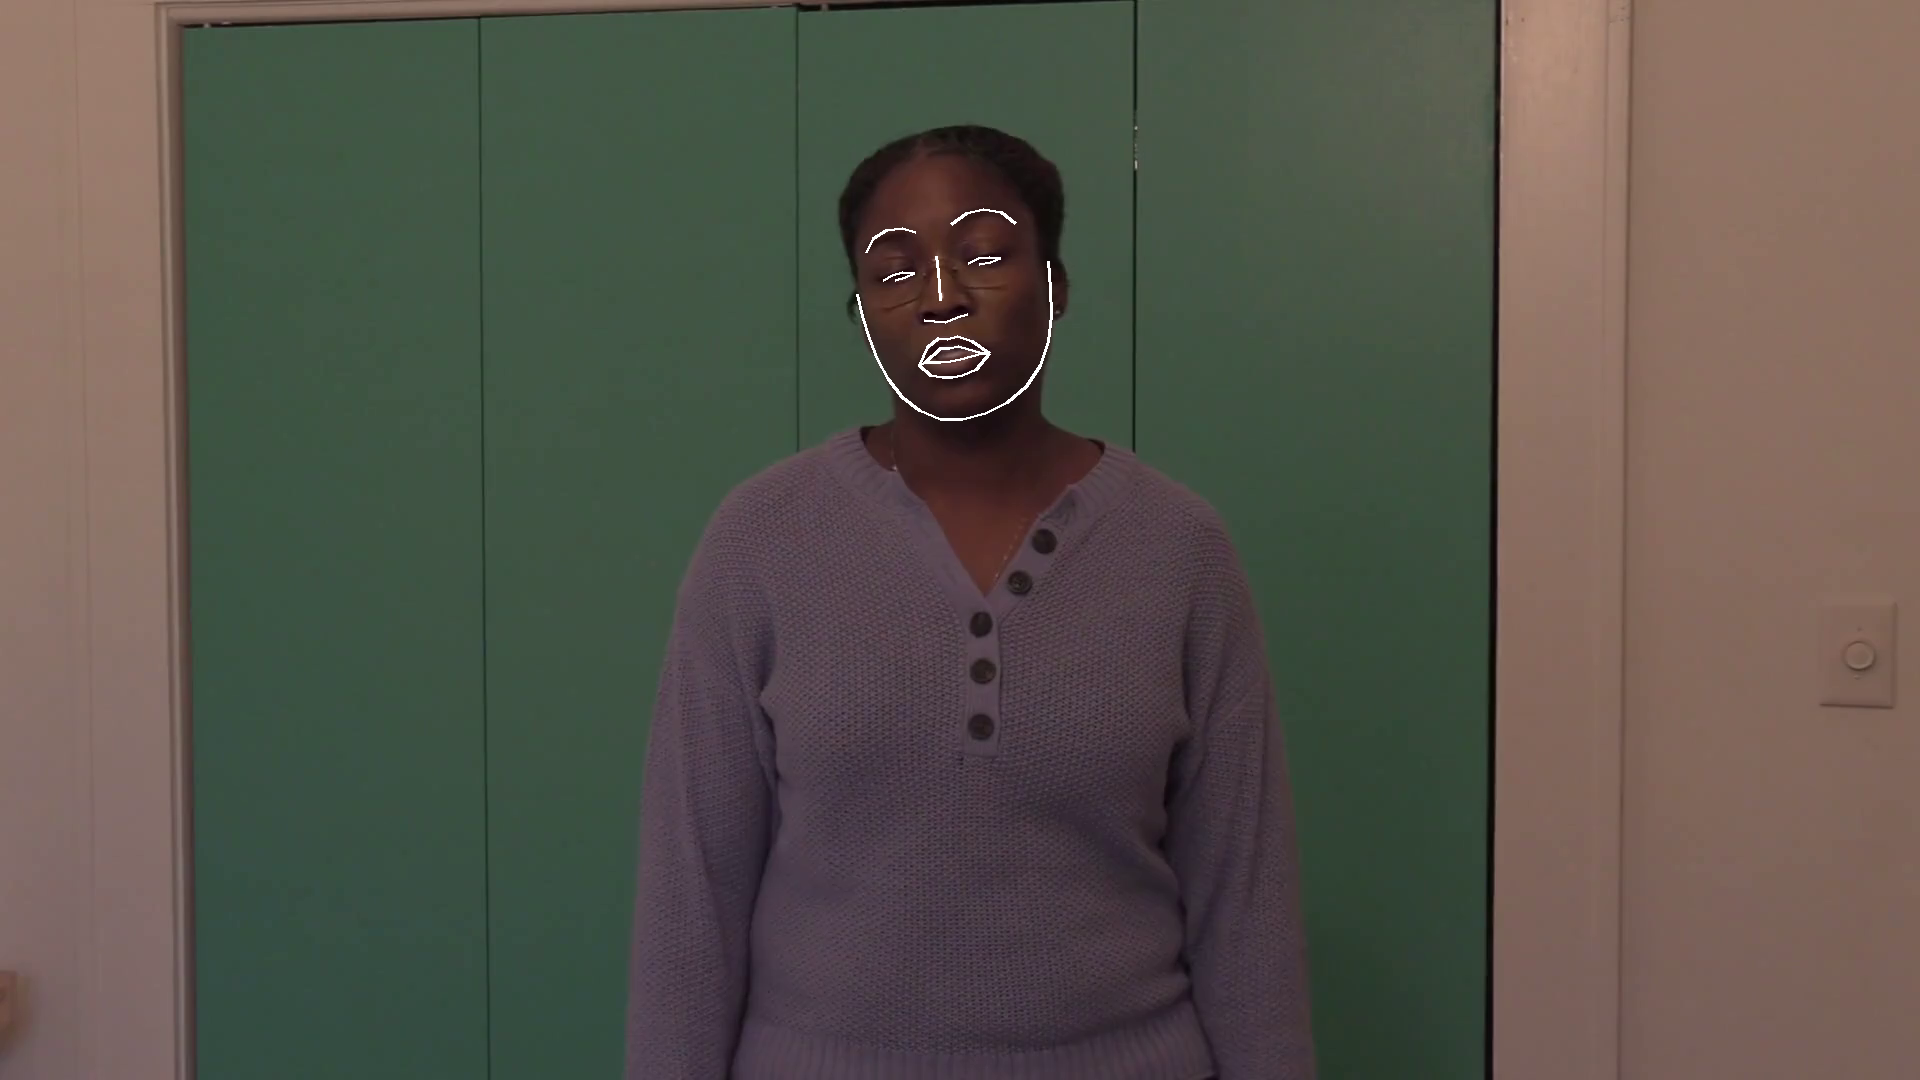

In [19]:
face_landmarks_list = face_recognition.face_landmarks(image)
from PIL import Image, ImageDraw
pil_image = Image.fromarray(image)
d = ImageDraw.Draw(pil_image)

for face_landmarks in face_landmarks_list:

    # Print the location of each facial feature in this image
    for facial_feature in face_landmarks.keys():
        print("The {} in this face has the following points: {}".format(facial_feature, face_landmarks[facial_feature]))

    # trace out each facial feature in the image with lines
    for facial_feature in face_landmarks.keys():
        d.line(face_landmarks[facial_feature], width=3)

# Show the picture
display(pil_image)

### Analysis of Facial Landmark Extraction

The extraction of facial landmarks lays the foundation for many advanced facial analysis tasks. The coordinates of key facial features like the eyes, nose, and mouth can be important in understanding the variations in facial geometry between genuine and deepfake videos. This analysis also opens avenues for feature engineering which is pivotal for building robust deepfake detection models. 


### Displaying Sample Test Examples with Labels

In this section, we display 4 video frames from the dataset, along with their labels indicating whether they are original or deepfake. Each pair comprises the original face image and the corresponding face image with facial landmarks drawn. The goal is to visually inspect the data and see if there are any distinguishable features between real and fake faces that could potentially be used for detection.

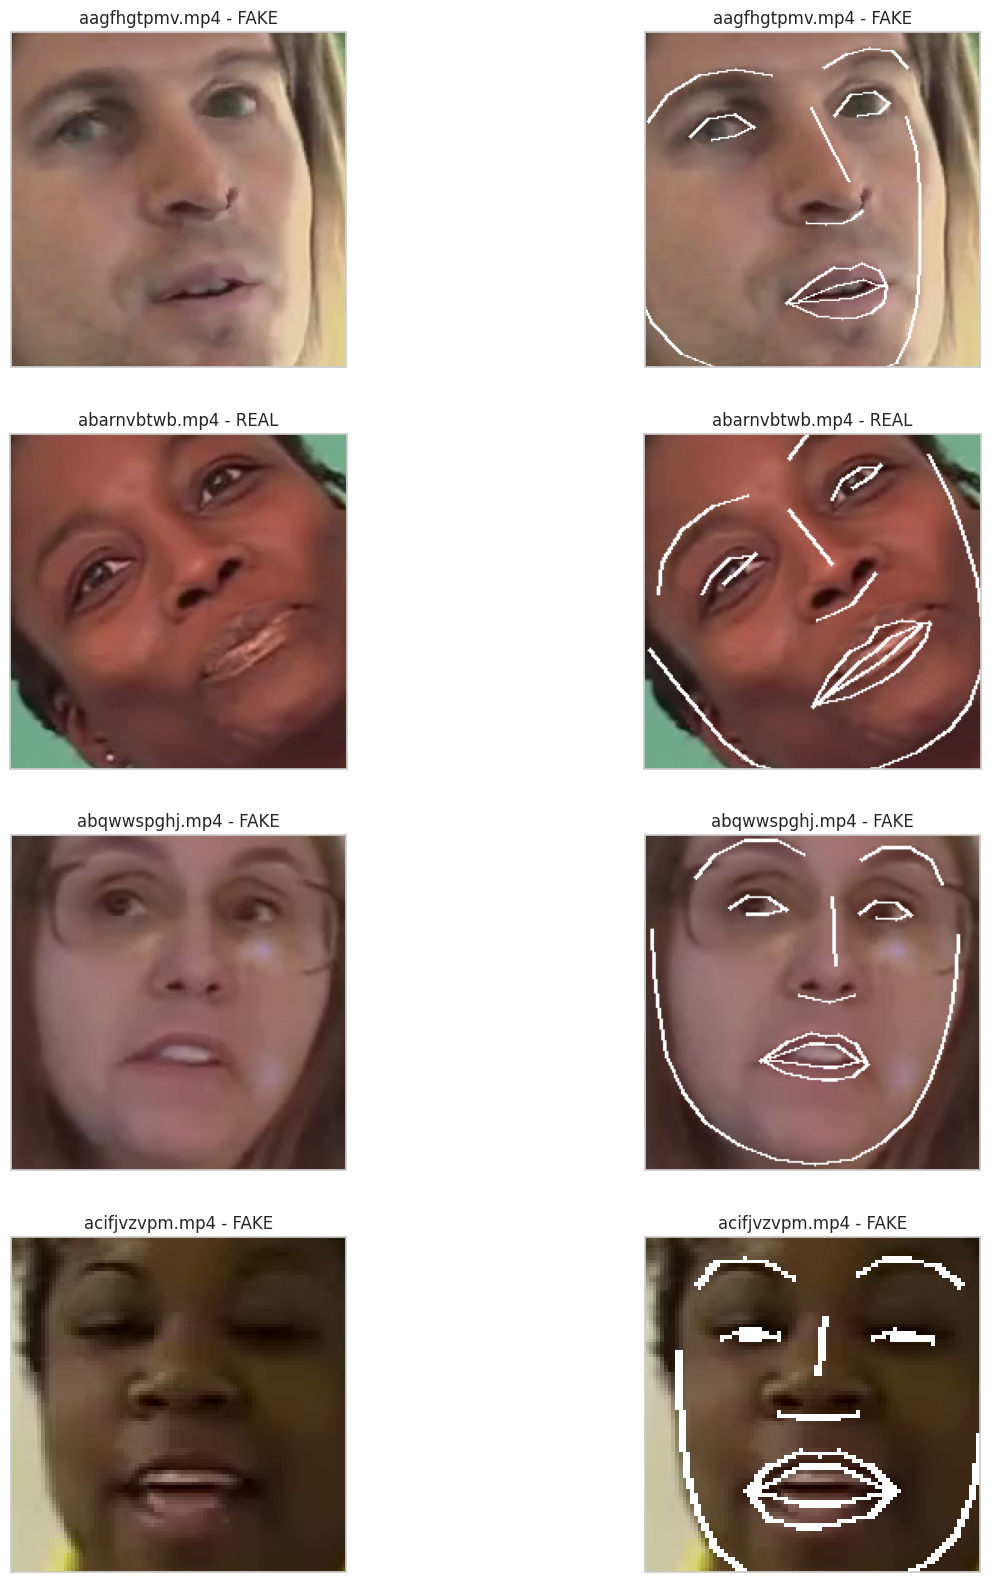

In [29]:
train_sample_metadata = pd.read_json('/data1/belalm/Capstone/sample_data/train_sample_videos/metadata.json').T
fig, axs = plt.subplots(4, 2, figsize=(15, 20))  
axs = axs.reshape(-1)
i = 0  # Index for subplots
j = 0  # Index for looping through videos
pairs_plotted = 0  # Counter for pairs plotted

while pairs_plotted < 4 and j < len(train_sample_metadata):  
    fn = train_sample_metadata.index[j]
    label = train_sample_metadata.loc[fn]['label']
    video_file = f'/data1/belalm/Capstone/sample_data/train_sample_videos/{fn}'  
    ax = axs[i]
    cap = cv.VideoCapture(video_file)
    success, image = cap.read()
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    face_locations = face_recognition.face_locations(image)
    if len(face_locations) > 0:
        # Print first face
        face_location = face_locations[0]
        top, right, bottom, left = face_location
        face_image = image[top:bottom, left:right]
        ax.imshow(face_image)
        ax.grid(False)
        ax.title.set_text(f'{fn} - {label}')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        # Find landmarks
        face_landmarks_list = face_recognition.face_landmarks(face_image)
        face_landmarks = face_landmarks_list[0]
        pil_image = Image.fromarray(face_image)
        d = ImageDraw.Draw(pil_image)
        for facial_feature in face_landmarks.keys():
            d.line(face_landmarks[facial_feature], width=2)
        landmark_face_array = np.array(pil_image)
        ax2 = axs[i+1]
        ax2.imshow(landmark_face_array)
        ax2.grid(False)
        ax2.title.set_text(f'{fn} - {label}')
        ax2.xaxis.set_visible(False)
        ax2.yaxis.set_visible(False)
        i += 2
        pairs_plotted += 1  # Increment the counter when a pair is plotted
    j += 1  # Increment the video index to process the next video

plt.grid(False)
plt.show()


## Analysis of Displayed Video Frames and Landmarks

In the displayed frames from four different videos, we observe that the facial landmarks are detected and outlined accurately on the faces present in the frames. These landmarks include contours around the eyes, eyebrows, nose, lips, and chin. This accuracy in facial landmark detection is crucial, as it forms the basis for further analysis and feature extraction for our deepfake detection. 

The outlined facial landmarks in the images provide a clear visual understanding of the distinct features that can be utilized to identify real versus manipulated content. Through this visualization, we can comprehend how a deep learning model might learn and extract features to distinguish between genuine and deepfake videos. 

Moving forward, leveraging these facial landmarks and other associated features will be essential in training a reliable deepfake detection model. The process of overlaying facial landmarks on the frames also validates the effectiveness and potential utility of facial recognition libraries in this project.


More EDA to be perofmed by belal